# t-SNE on Amazon Fine Food Data

<b>t-SNE</b> :-t-distributed Stochastic Neighbor Embedding.

<b>What is t-SNE</b> 

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance.

-what is distribution?

Used to solve the crowding problem.

what is Neighborhood?

Points that are geometrically closed.

what is Embedding?

Finding low dimensional space for points given in higher dimensional space.

How does it do?


It preserves local structure of data.

Important parameters

perplexity: Number of points considered as neighbor geometrically.

n_iter: Number of iterations to be repeated

<b>Important this that to kept in mind while training t-SNE?</b>
 
-->Always run t-SNE with multiple perplexity values until it reaches to stabilized shape

-->if perplexity values  = number of data points it will become a mess 

-->perplexity should be less then < number of data points

-->Never run t-SNE with different perplexity and stepsize until shape stabilize 


NOTE:- t-sne is a iterative algoritm(stochastic algorithm). Eventually it wants to reach a stage that clusters are no long moving.it tires to find embeddings in each iteration

<b>About</b>

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories.


<b>Data</b>

Number of reviews: 568,454.

Number of users: 256,059.

Number of products: 74,258.

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

<b> Data consist of </b>

1.ID

2.productID

3.userID: unique ID for every customer

4.score:-rating 1-5

5.Helpfulness numerator :- how many customers find reviews  helpful

6.Helpfulness Denominator :- How Many customers find the review helpful or not

7.Text:- text of the review

8.Summary

9.Time :- time stamp

10.Profile Name



<b>objective</b>

Visualizing higher dimensions data using t-SNE

Here to achieve this task we use dimensionality reduction technique called t-sne it visually represent the higher dimension data in lower dimensions.In this technique we will see if the data is separable or not based on its polarity.

<b>How to achieve this Task?</b>

From the data using Scoring attribute .A rating of 4-5 stars can be consider as Positive review and with rating 1-2 can be consider as 
 Negative review and score with 3 is neglected because it was neutral review we cant decide whether its a positive or negative review.

In [1]:
#importing required librarie
%matplotlib inline
import os 
import pandas as pd  #data analysis
import numpy as np #scientific computation
import seaborn as sns #ploting tool
import matplotlib.pyplot as plt #ploting tool
import sqlite3 #for Sql
import re # This module provides regular expression matching operations

#Natural Language processing toolkit

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import pickle

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

    
    


In [2]:
link = sqlite3.connect("C:/users/rock/Documents/database.sqlite") #linking with sql data 

#Taking only postive and negative reviews im not considering neutral reviws 3

df = pd.read_sql_query("""SELECT* FROM Reviews WHERE Score !=3 """,link)

In [52]:
#give reviews with score >3 as positive and <3 gives neagitve
def split (x):
    if x<3:
        return "negative"
    return "positive"

#converting to postive and negative scores 

actualScore = df["Score"]
PostiveNegative = actualScore.map(split)
df["Score"]=PostiveNegative


df['Labels'] =df['Score'].apply(lambda x: 1 if x=='positive' else 0)

df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


# Data Preprocessing 

<b>Data Cleaning </b> basically means removing the false and duplicate entries from the original data .This is the most important step in Machine learning Becoz our data consists of lots of misleading and duplicate entries if we give this data to our algorthim it will loose its accuracy.So for better output we clean Data Everytime when we are dealing with a data set

After cleaning data we do some feature engineering steps to feed the data to our algorithm

We here convert some categorical features to numerical feature vector to feed our algorithm .ML models takes numerical data to train the model .we cant use categorical data to feed our model.So feature engineering is the most important step

BY observing the data we can see some reviews has duplicate entires in our dataset  lets look how many reviews has duplicate entries


In [54]:
display= pd.read_sql_query (""" SELECT  UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
                        FROM Reviews 
                        GROUP BY UserId
                        HAVING COUNT(*)>1
                                """,link)

In [55]:
display.shape

(80668, 7)

In [56]:
display["Score"].value_counts()

5    51719
4    11142
1     7462
3     5979
2     4366
Name: Score, dtype: int64

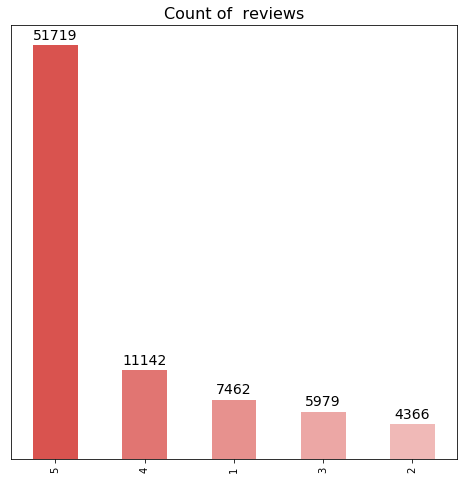

In [57]:
ax = display["Score"].value_counts().plot(kind='bar', 
                figsize=(8, 8),
                rot=90,color = ['#D9534F','#E17572','#E7918E','#ECA7A5','#F0B9B7'])

ax.set_title('Count of  reviews',fontsize=16)
ax.set_facecolor('white')
ax.get_yaxis().set_visible(False) #removing boader
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
plt.show()


In [58]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="#oc-R11DNU2NBKQ23Z"
ORDER BY ProductID
""", link)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,83657,B005ZBZLT4,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...
1,181211,B007Y59HVM,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...


Here You can see That user Kim Cieszykowski has the same reviews ,HelpfulnessNumerator and Helpfulnessdenominator,time,stamp,userid.

Obsereve that product ID is different but remaining attributes that means Kim's review is gost updated for two prodcut at the same time. This will happen because the product has the same brand name, same quantity and different flavour.

Its important to delete this dupliate entires for this I use <b>drop_duplicate()</b> fucntion from pandas.


In [59]:
#soting the data according to productid 
sd=df.sort_values("ProductId",axis=0,ascending=True)

#dropng the duplicates 
resulted_data= sd.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [60]:
resulted_data.shape

(364173, 11)

ere you can observe that from 500k data points we remain with only 360K+ data points.I our data we nearly have 30 % of duplicate values.

In [61]:
resulted_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'Labels'],
      dtype='object')

In [62]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", link)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [63]:
resulted_data=resulted_data[resulted_data.HelpfulnessNumerator<=resulted_data.HelpfulnessDenominator]

In [64]:
resulted_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

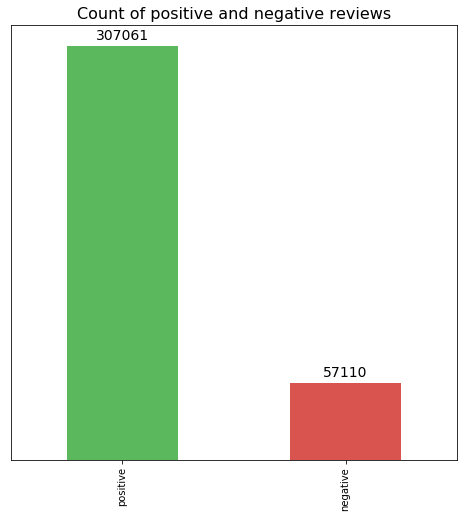

In [65]:
ax = resulted_data["Score"].value_counts().plot(kind='bar', 
                figsize=(8, 8),
                rot=90,color = ['#5cb85c','#d9534f'])

ax.set_title('Count of positive and negative reviews',fontsize=16)
ax.set_facecolor('white')

# setting legend font size
#ax.legend(fontsize=14,facecolor = 'white') 

ax.get_yaxis().set_visible(False) #removing boader
 #Creating a function to display the values on top.
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
plt.show()

# Data Preprocessing

In [66]:
#removing stopwords
check1=resulted_data["Text"].values[20]
print(check1)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


From the bove Text u can observe that a single text contains lots of junk like:html tags,upper cases,loweer cases,angular bases ,puntuations,symbols.
 To clean this we undergoes into <b>Text Preprocessing</b> STEPS:-
 
<b>
1 - Tokenization
    
2 - Normalization

3 - Substution
</b>



Click this link for Clear Understanding off this concept:-https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html

<b>https://pymotw.com/3/re/ :-documentaion on RE 
    
if you find dificult in understanding the above RE documentaion  then Refer this Blog:-</b>
    
https://www.pythonforbeginners.com/regex/regular-expressions-in-python

In [67]:
check1 = re.sub(r"Didn\'t", "did not",check1) #converting the punctuations
print(check1)

print("++"*125)

check1=re.sub('[^A-Za-z0-9]+', ' ',check1)
print(check1)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who did not Care), but it still carries his unique brand of charm.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
In June br I saw a charming group br of roses all begin br to droop br I pepped them up br with chicken soup br Sprinkle once br sprinkle twice br sprinkle chicken soup br with ric

In [68]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer

In [69]:
from nltk.corpus import stopwords

stop =set(stopwords.words('english'))

#keeping some contextual words

print(stop)

#for stemming
stemm= SnowballStemmer(language="english") #

print("----"*30)

print(stemm.stem("beautiful"))


{'few', 'she', 'here', 'me', 'll', 'under', 'your', 'now', 'and', 'own', 'on', 'don', 'out', 'above', 'himself', 'my', 'when', 'only', 'ain', 'our', 'their', 'you', 'down', 'yours', 'has', 'did', 'very', 'was', 'haven', 'for', "needn't", 'off', "hadn't", 'yourselves', 'during', 'are', 'do', 'through', "you'll", 'because', 'after', 'does', "that'll", 'by', "didn't", "hasn't", "mightn't", 'have', 'needn', 'so', 'shouldn', 'just', 'below', 'will', 'nor', 'd', 'into', 'to', 'how', "isn't", 'were', 'won', 'aren', 'at', 'm', "aren't", 'why', 'if', 'some', "you'd", 'between', 'what', 'is', 'of', "don't", 'having', 'couldn', 'should', 'in', 'wouldn', 'his', 'itself', 'that', 'or', 'until', 'most', 'doesn', 'hadn', 'such', 'other', 'we', 'doing', 'be', 'against', "shan't", 's', "haven't", 'didn', 'can', 'i', 'once', 'over', 'then', 'further', "should've", "shouldn't", 'he', 'who', 'each', 'both', "wouldn't", 'no', "doesn't", 'hasn', "mustn't", 'about', 'weren', 'ourselves', 'herself', "wasn't",

In [70]:
#for stemming
stemm= SnowballStemmer(language="english") #

def cleanhtml(sent):
    cleaner = re.compile('<.*>')
    cleantext = re.sub(cleaner, ' ', sentence)
    return cleantext

def cleanpunc(sent):
    cleaned = re.sub(r'[?|.|!|*|@|#|\'|"|,|)|(|\|/]', r'', sentence)
    return cleaned



In [71]:
#cleaning whole data 
i=0 
string =" "
for_positive_words =[] #storing positve words 
for_negative_words =[] #storing negatie words 
final_string=[] # list of final striing after all the processsing 
s=""

for sentence in tqdm (resulted_data["Text"].values):
    filtered_data=[] 
    sentence = cleanpunc(sentence)
    sentence = cleanhtml(sentence)
    for processed_words in sentence.split(): 
        if(processed_words.isalpha()) & (len(processed_words)>2):
            if(processed_words.lower() not in stop):
                s = (stemm.stem(processed_words.lower())).encode("utf8")
                filtered_data.append(s)
                if (resulted_data["Score"].values)[i]=="positive":
                    for_positive_words.append(s) # appending to all the positive reviews
                if (resulted_data["Score"].values)[i]=="negative":
                    for_negative_words.append(s) # 
            else:
                continue
        else:
            continue
    
    string =b" ".join(filtered_data) # joinging to final string of processed words
    final_string.append(string)
    i +=1

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:44<00:00, 1623.30it/s]


In [78]:
# Adding new column into dataframe to store cleaned text
resulted_data['CleanedText'] = final_string
resulted_data['CleanedText'] = resulted_data['CleanedText'].str.decode('utf-8')


In [79]:
# Creating new dataset with cleaned text for future use
conn = sqlite3.connect('resulted_data.sqlite')
c = conn.cursor()
conn.text_factory = str
resulted_data.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [80]:
print(resulted_data.shape)

(364171, 12)


In [2]:
# Creating connection to read from database
conn = sqlite3.connect('./resulted_data.sqlite')

# Creating data frame for visualization using sql query
resulted_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn)

In [90]:
resulted_data.to_csv("resulted_data.csv")

In [8]:
resulted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Labels,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",1,grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,1,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,1,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,1,book poetri month year goe month cute littl po...


In [5]:
print(df1["Score"].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


For T-sne iterating 500K data set will take alot time to process so for simplycity im taking only 2000 data points to visualize 

for this im taking a sample of data from 2000 positive reviews and 2000 negative reviews and keeping this in data frame total 

In [3]:
pos=resulted_data[resulted_data["Score"]=="positive"].sample(n=4000)
neg = resulted_data[resulted_data["Score"]=="negative"].sample(n=4000)

total = pd.concat([pos,neg])

# Bag of Words

Want to know about Bag of Words :-https://en.wikipedia.org/wiki/Bag-of-words_model

In BoW we construct a dictionary that contains set of all unique words from our text review dataset.The frequency of the word is counted here. if there are d unique words in our dictionary then for every sentence or review the vector will be of length d and count of word from review is stored at its particular location in vector. The vector will be highly sparse in such case.



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(8000, 12072)
(8000, 12072)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


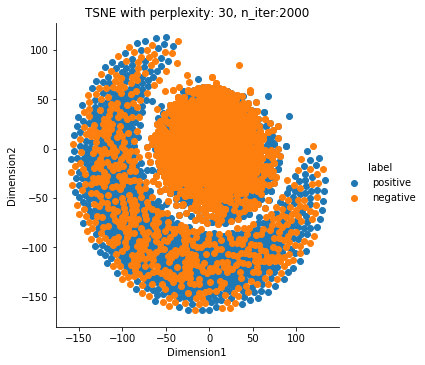

Wall time: 27min 1s


In [110]:
%%time
# Initializing vectorizer for bigram
count_vect = CountVectorizer(ngram_range=(1,1))

# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

# Creating count vectors and converting into dense representation
sample_points = total['CleanedText']
sample_points = count_vect.fit_transform(sample_points)
sample_points = std_scaler.fit_transform(sample_points)
sample_points = sample_points.todense() #t-sne dont work on sparse matrix so we transforing into densee matrix

# Storing class label in variable
labels = total['Score']

# Getting shape
print(sample_points.shape)





tsne_data =sample_points
tsne_labels = labels

# Initializing with perplexity=20 and n_iter = 2000
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=2000)

# Fitting model
tsne_data = model.fit_transform(tsne_data)

# Adding labels to the data point
tsne_data = np.vstack((tsne_data.T, tsne_labels)).T

# creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dimension1', 'Dimension2', 'label'))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dimension1', 'Dimension2').add_legend()
plt.title("TSNE with perplexity: 30, n_iter:2000")
plt.xlabel("Dimension1")
plt.ylabel("Dimension2")
plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(8000, 12141)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


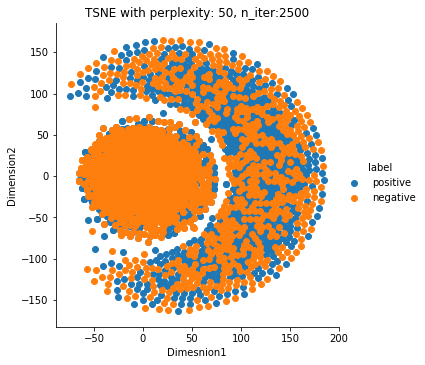

Wall time: 55min 1s


In [10]:
%%time
# Initializing vectorizer for bigram
count_vect = CountVectorizer()

# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

# Creating count vectors and converting into dense representation
sample_points = total['CleanedText']
sample_points = count_vect.fit_transform(sample_points)
sample_points = std_scaler.fit_transform(sample_points)
sample_points = sample_points.todense() #t-sne dont work on sparse matrix so we transforing into densee matrix

# Storing class label in variable
labels = total['Score']

# Getting shape
print(sample_points.shape)


tsne_data = sample_points
tsne_labels =  labels

# Initializing with perplexity=50 and n_iter = 2500
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=2500)

# Fitting model
tsne_data = model.fit_transform(tsne_data)

# Adding labels to the data point
tsne_data = np.vstack((tsne_data.T, tsne_labels)).T

# creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dimension1', 'Dimension2', 'label'))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dimension1', 'Dimension2').add_legend()
plt.title("TSNE with perplexity: 50, n_iter:2500")
plt.xlabel("Dimesnion1")
plt.ylabel("Dimension2")
plt.show()



# TF-idf

For better understanding t-sne refer this blog :- https://colah.github.io/posts/2014-10-Visualizing-MNIST/

(8000, 12141)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


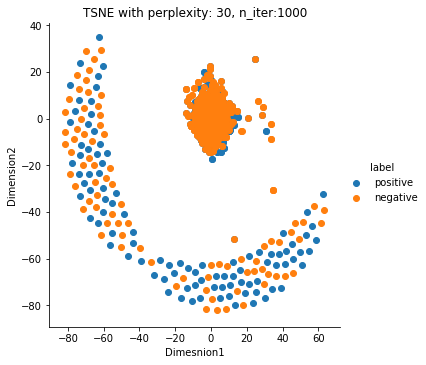

Wall time: 28min 10s


In [21]:
%%time
# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

tf_idf_vec= TfidfVectorizer(ngram_range=(1,1))#unigram

tf_points = total['CleanedText']
tf_points = tf_idf_vec.fit_transform(tf_points)
tf_points = std_scaler.fit_transform(tf_points)
tf_points =tf_points.todense() #t-sne dont work on sparse matrix so we transforing into densee matrix

labels = total['Score']

tfidf_labels =labels
print(tf_points.shape)



model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)

# Fitting model
tsne_data = model.fit_transform(tf_points)


tsne_data = np.vstack((tsne_data.T, tfidf_labels)).T

# Creating  a data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dimension1', 'Dimension2', 'label'))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dimension1', 'Dimension2').add_legend()
plt.title("TSNE with perplexity: 30, n_iter:1000")
plt.xlabel("Dimesnion1")
plt.ylabel("Dimension2")
plt.show()

# t-SNE for bi-gram

In [ ]:
%%time
# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

tf_idf_vec= TfidfVectorizer(ngram_range=(1,2))#unigram

tf_points = total['CleanedText']
tf_points = tf_idf_vec.fit_transform(tf_points)
tf_points = std_scaler.fit_transform(tf_points)
tf_points =tf_points.todense() #t-sne dont work on sparse matrix so we transforing into densee matrix

labels = total['Score']

tfidf_labels =labels
print(tf_points.shape)



model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)

# Fitting model
tsne_data = model.fit_transform(tf_points)


tsne_data = np.vstack((tsne_data.T, tfidf_labels)).T

# Creating  a data frame
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dimension1', 'Dimension2', 'label'))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dimension1', 'Dimension2').add_legend()
plt.title("TSNE with perplexity: 30, n_iter:1000")
plt.xlabel("Dimesnion1")
plt.ylabel("Dimension2")
plt.show()

(8000, 171608)
